# Docs
*   https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/

# Libs

In [ ]:
!nvidia-smi

Tue May  9 10:14:34 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   44C    P8               35W / 450W|   1693MiB / 24564MiB |     40%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!/opt/bin/nvidia-smi
!nvcc --version

The system cannot find the path specified.


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Get the dataset
!mkdir clouds1500_no_tree
!tar -xf "/home/Datasets/clouds1500_no_tree.tar" -C clouds1500_no_tree

mkdir: cannot create directory ‘clouds1500_no_tree’: File exists


## Install required packages


In [ ]:
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install albumentations==0.4.6
!pip install efficientunet-pytorch
!pip install torchmetrics

In [ ]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
from efficientunet import *
from torch.utils.data import DataLoader, Dataset
# from google.colab import drive


# Set GPU device to use
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

# Define directory paths


In [ ]:
root_directory = os.path.join("clouds1500_no_tree/")
images_directory = os.path.join(root_directory, "train")
masks_directory = os.path.join(root_directory, "train_mask")

test_images_directory = os.path.join(root_directory, "test")
test_masks_directory = os.path.join(root_directory, "test_mask")

val_images_directory = os.path.join(root_directory, "validation")
val_masks_directory = os.path.join(root_directory, "validation_mask")

random.seed(42)

train_images_filenames = list(sorted(os.listdir(images_directory)))
test_images_filenames = list(sorted(os.listdir(test_images_directory)))
val_images_filenames = list(sorted(os.listdir(val_images_directory)))


print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

1227 28 223


# Pre-process

This function takes a mask image as input and converts it into a format that can be used as ground truth for training. It maps each unique color in the mask image (representing different classes) to a corresponding integer label. The function processes the mask by iterating through its pixels, converting the colors to their corresponding labels using a dictionary, and reshaping the mask back to its original dimensions.

In [ ]:
def preprocess_mask(mask):
    # Define colors in the mask for each class
    background = str([0, 0, 0])
    color_estratocumuliformes = str([1,1,1])
    color_estratiformes = str([2,2,2])
    color_cirriformes = str([3,3,3])
    color_cumuliformes = str([4,4,4])

    # Map colors to integer labels
    labels = {background:0, color_estratocumuliformes:1, color_estratiformes:2, color_cirriformes:3, color_cumuliformes:4}

    width = mask.shape[1]
    height = mask.shape[0]

    # Convert mask colors to corresponding integer labels
    values = [str(list(mask[i,j])) for i in range(height) for j in range(width)]
    mask = [labels[value] for value in values]

    # Reshape mask to the original dimensions
    mask = np.asarray(mask).reshape(height, width)

    return mask

This class inherits from the PyTorch Dataset class and is designed to handle the images and masks of the dataset. The constructor takes the filenames, directories, and an optional transform as input. The class has two main methods: __len__ returns the number of images in the dataset, and __getitem__ reads the image and mask at the specified index, preprocesses the mask using the preprocess_mask function, and applies any provided transformations to the images and masks.

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        # Read image and mask based on the provided index
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )

        # Preprocess the mask
        mask = preprocess_mask(mask)

        # Apply provided transformations to the image and mask
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask


`train_transform` and `val_transform` are defined using the Albumentations library to perform image augmentations and preprocessing. The transformations include resizing the images and converting them to PyTorch tensors. For the training set, more augmentations can be uncommented for data augmentation, and normalization can be added.

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(1280, 1280),
#         A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
#         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [
        A.Resize(1280, 1280),
        # A.Normalize(mean=(0.485, 0.456, 0.406),
        #             std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
     ]
)
val_dataset = OxfordPetDataset(val_images_filenames, val_images_directory, val_masks_directory, transform=val_transform,)

The `MetricMonitor` class provides a convenient way to monitor and display the performance of different metrics during the training or evaluation of a machine learning model. The reset method can be called to reset the metrics before each epoch or evaluation, while the update method can be used to update the metrics with new values after each batch or evaluation step. Finally, the `__str__` method can be called to display the current state of the metrics in a readable format.

* `__init__(self, float_precision=3)`: This is the class constructor method that initializes the object with a default float_precision of 3. The float_precision parameter determines the number of decimal points to display in the output of the __str__ method.

* `reset(self)`: This method resets all the metric values stored in the object. It does this by setting all the values of val, count, and avg to zero using a defaultdict.

* `update(self, metric_name, val)`: This method updates the stored metric values with new values. It takes two parameters: metric_name, a string that represents the name of the metric to update, and val, a float value that represents the value of the metric. This method increments the count of the metric by 1 and adds the new value to the running total. It then calculates the average of the metric using the running total and count.

* `__str__(self)`: This method returns a formatted string of the metric values stored in the object. It returns a string with the average values of all metrics in the object. The string contains the metric name followed by its average value rounded off to the specified float_precision decimal points.

In [ ]:
from collections import defaultdict

class MetricMonitor:
    def __init__(self, float_precision=3):
        # Constructor method that initializes the object with a default float_precision of 3
        self.float_precision = float_precision
        # Calls the reset method to set the initial state of the metrics
        self.reset()

    def reset(self):
        # Resets all metric values to zero using a defaultdict with a lambda function
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        # Updates the stored metric values with new values
        metric = self.metrics[metric_name]

        # Increment the count of the metric by 1 and add the new value to the running total
        metric["val"] += val
        metric["count"] += 1

        # Calculate the average of the metric using the running total and count
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        # Returns a formatted string of the metric values stored in the object
        return " | ".join(
            [
                # Format the metric name and its average value using the float_precision parameter
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                # Iterate over all the metrics stored in the object and create a string for each one
                for (metric_name, metric) in self.metrics.items()
            ]
        )


The `train` function provides a convenient way to train a PyTorch neural network model on a given dataset using a specified loss function, optimizer, and hyperparameters. It also tracks the training loss and displays the progress of the training process using a MetricMonitor object and a tqdm progress bar.

The function takes several parameters:

* `train_loader`: A PyTorch DataLoader object that provides the training dataset in batches
model: A PyTorch neural network model to train
* `criterion`: A loss function used to calculate the error between the model's predictions and the target labels
* `optimizer`: A PyTorch optimizer that updates the model's parameters during training
* `epoch`: An integer that represents the current epoch of training
* `params`: A dictionary that contains various hyperparameters for the training process, including the device (CPU or GPU) to use for processing the data.

The function first creates a MetricMonitor object to keep track of the training loss during training. It then sets the model to training mode and wraps the train_loader with a tqdm progress bar to display the progress of the training process.

The function then loops over the batches in the train_loader and performs the following steps for each batch:

* Moves the input images and target labels to the device (CPU or GPU) for faster processing
* Computes the model's predictions for the input images using the model object
* Calculates the loss between the model's predictions and the target labels using the criterion object
* Updates the MetricMonitor object with the current loss value using the update method
* Zeros out the gradients from the previous batch using the `optimizer.zero_grad()` method
* Computes the gradients of the loss with respect to the model's parameters using the `loss.backward()` method
* Updates the model's parameters based on the computed gradients using the `optimizer.step()` method
* Updates the tqdm progress bar with the current epoch and the training metrics using the `stream.set_description()` method.

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True).float()
        target = target.to(params["device"], non_blocking=True).type(torch.LongTensor)
        output = model(images.cuda()).squeeze(1)
        loss = criterion(output.cuda(), target.cuda())
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

The `validate` function provides a convenient way to validate a PyTorch neural network model on a given dataset using a specified loss function, and hyperparameters. It also tracks the validation loss and displays the progress of the validation process using a `MetricMonitor` object and a `tqdm` progress bar.

The function takes several parameters:

* `val_loader`: A PyTorch DataLoader object that provides the validation dataset in batches
model: A PyTorch neural network model to validate
* `criterion`: A loss function used to calculate the error between the model's predictions and the target labels
* `epoch`: An integer that represents the current epoch of validation
* `params`: A dictionary that contains various hyperparameters for the validation process, including the device (CPU or GPU) to use for processing the data.

The function first creates a `MetricMonitor` object to keep track of the validation loss during validation. It then sets the model to evaluation mode (i.e., turns off dropout and batch normalization) and wraps the `val_loader` with a `tqdm` progress bar to display the progress of the validation process.

The function then loops over the batches in the `val_loader` and performs the following steps for each batch:
* Moves the input images and target labels to the device (CPU or GPU) for faster processing
* Computes the model's predictions for the input images using the `model` object
* Calculates the loss between the model's predictions and the target labels using the `criterion` object
* Updates the `MetricMonitor` object with the current loss value using the update method
* Updates the `tqdm` progress bar with the current epoch and the validation metrics using the `stream.set_description()` method.

Note that the `torch.no_grad()` context manager is used to turn off gradient tracking during validation to save memory and speed up the computation.

In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True).float()
            target = target.to(params["device"], non_blocking=True).type(torch.LongTensor)
            output = model(images.cuda()).squeeze(1)
            loss = criterion(output.cuda(), target.cuda())
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

# Training

## Training Params
Defining PyTorch DataLoader objects, train_loader and val_loader, that provide the training and validation datasets in batches during the training process.

* `device`: A string that represents the device (CPU or GPU) to use for processing the data.
* `lr`: A float that represents the learning rate for the optimizer during training.
* batch_size: An integer that represents the number of samples to process in each batch during training.
* `num_workers`: An integer that represents the number of CPU workers to use for loading the data in parallel during training.
* `epochs`: An integer that represents the number of epochs to train the model.

Each DataLoader object takes several arguments:

* The first argument is a PyTorch `Dataset` object that provides the dataset to load.
* `batch_size`: An integer that represents the number of samples to process in each batch during training or validation.
* `shuffle`: A boolean that indicates whether to shuffle the data between epochs (for the `train_loader` only).
* `num_workers`: An integer that represents the number of CPU workers to use for loading the data in parallel.
* `pin_memory`: A boolean that indicates whether to copy the data to pinned memory for faster transfer to the GPU (for the `train_loader` and `val_loader` objects).


Overall, the `DataLoader` objects provide a convenient way to load the training and validation data in batches during the training process, with various hyperparameters specified in the params dictionary.

In [ ]:
params = {
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 2,
    "num_workers": 0,
    "epochs": 1,
}

train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=params["batch_size"],
    shuffle=False,
    num_workers=params["num_workers"],
    pin_memory=True,
)

## Training the model
Here we train a PyTorch neural network model called `get_efficientunet_b0` on a given dataset using the specified hyperparameters.

We first creates the `get_efficientunet_b0` model and loads its weights from a pre-trained checkpoint using `load_state_dict()`. It also creates a CrossEntropyLoss loss function and an Adam optimizer with the specified learning rate and model parameters.

We then train the model using a `for` loop that iterates over the specified number of epochs (from 0 to `params["epochs"] + 1`). For each epoch, the code calls the train function to train the model on the training dataset and updates the model parameters using the optimizer. It also calls the `validate` function to validate the model on the validation dataset and prints the validation metrics.

### **Important Notes**
Note that we save the model checkpoint after each epoch using `torch.save()` with the model's state dictionary and the current epoch number in the file name. This allows for resuming training later by changing the range of the `for` loop to continue training from the last saved checkpoint.

#### Example
Suppose you have trained the model for `10 epochs` and want to continue training for an additional `5 epochs`. You can change the range of the for loop to start from epoch 11 and train for 5 additional epochs as follows:

```python
for epoch in range(11, 16):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)
    torch.save(model.state_dict(), "dir/"+str(epoch)+".pth")
```

In [ ]:
# Create the EfficientUNet-B0 model with specified parameters and load its weights from a saved checkpoint
model = get_efficientunet_b0(out_channels=6, concat_input=True, pretrained=True).to("cuda")
# model.load_state_dict(torch.load('/content/drive/Shareddrives/Nuvens/resultados_pytorch/Bruno/unet_efficientnet/clouds_1500/com_arvore/results/8.pth'))

# Define the loss function and optimizer with specified hyperparameters
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

# Train the model for the specified number of epochs and save the checkpoints
for epoch in range(0, params["epochs"] + 1):
    # Train the model on the training dataset and update the model parameters using the optimizer
    train(train_loader, model, criterion, optimizer, epoch, params)

    # Validate the model on the validation dataset and print the validation metrics
    validate(val_loader, model, criterion, epoch, params)

    # Save the model checkpoint after each epoch with the current state dictionary and epoch number
    torch.save(model.state_dict(), "path_to_save//"+str(epoch)+".pth")


Load a pre-trained `EfficientUNet-B0` model from a saved checkpoint and sets it to evaluation mode.

The code first creates the `EfficientUNet-B0` model with specified parameters using the `get_efficientunet_b0` function. The `out_channels` parameter specifies the number of output channels in the final layer, `concat_input` specifies whether to concatenate the input with the final feature map, and `pretrained` specifies whether to load the pre-trained weights. The model is then moved to the GPU using the to() method.

Then, the code loads the weights of the model from a saved checkpoint using the `load_state_dict()` function. The path of the checkpoint file is specified in the argument of the `load_state_dict()` function.

Finally, the code sets the model to evaluation mode using the `eval()` method. This is necessary to disable certain layers of the model (such as dropout or batch normalization) that behave differently during training and testing, and to ensure that the model outputs deterministic predictions.

In [ ]:
# Load the EfficientUNet-B0 model with specified parameters and load its weights from a saved checkpoint
model = get_efficientunet_b0(out_channels=5, concat_input=True, pretrained=True).to("cpu")
model.load_state_dict(torch.load('path_to_save/12.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()


# Inference



The class inherits from the Dataset class in PyTorch and overrides the `__init__()`, `__len__()`, and `__getitem__()` methods. The `__init__()` method initializes the dataset with a list of image filenames, the directory containing the images, and an optional transform to be applied to the images. The `__len__()` method returns the number of images in the dataset, and the `__getitem__()` method loads an image from disk, applies the transformation (if any), and returns the transformed image and its original size.

Specifically, the code reads an image from disk using the cv2.imread() function from the OpenCV library and converts it from the BGR color format to the RGB format using `cv2.cvtColor()`. The original size of the image is also computed and returned along with the transformed image.

In [ ]:
# Define a PyTorch dataset class for inference on the Oxford-IIIT Pet dataset
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        # Read image and mask based on the provided index
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )

        # Preprocess the mask
        mask = preprocess_mask(mask)

        # Apply provided transformations to the image and mask
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask, image_filename


Similar to the previous class, the `OxfordPetInferenceMaskDataset` class inherits from the `Dataset` class and overrides the `__init__()`, `__len__()`, and `__getitem__()` methods. The class is initialized with a list of image filenames, the directory containing the images, the directory containing the masks, and an optional transform to be applied to the masks.

The `__getitem__()` method first loads the mask associated with the image using the OpenCV library, by replacing the ".jpg" extension with ".png" to get the mask filename. The mask is then preprocessed using a `preprocess_mask()` function (not shown in the code snippet). If a transform is provided, it is applied to the mask and the transformed mask is returned.

In [ ]:
# Define a PyTorch dataset class for loading and transforming ground truth masks of the Oxford-IIIT Pet dataset
class OxfordPetInferenceMaskDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        # Load the mask associated with the image and preprocess it
        image_filename = self.images_filenames[idx]
        mask = cv2.imread(os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED)
        mask = preprocess_mask(mask)

        # Apply the transformation (if any) and return the transformed mask
        if self.transform is not None:
            transformed = self.transform(image=mask)
            mask = transformed["image"]
        return mask


## Calculate metrics for each class

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# define the transformation to be applied to the test images
test_transform = A.Compose(
    [
        A.Resize(1280, 1280),
        # A.Resize(2592, 1944),
        # A.Normalize(mean=(0.485, 0.456, 0.406),
        #             std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
     ]
)

# define the batch size for the test dataloader
batch_size = 2

# create the test dataset
test_dataset = OxfordPetDataset(test_images_filenames, test_images_directory, test_masks_directory, transform=test_transform)

# create the test dataloader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=params["num_workers"], pin_memory=True)

# create an empty confusion matrix to store the predictions
conf_matrix = torch.zeros((6, 6), dtype=torch.int64)

# put the model on CPU
model = model.to("cpu")
model.eval()

# iterate over the test dataloader
with torch.no_grad():
    for images, targets in test_loader:
        outputs = model(images.float())
        _, preds = torch.max(outputs, dim=1)
        # calculate the confusion matrix for the current batch
        conf_matrix += confusion_matrix(targets.flatten(), preds.flatten(), labels=list(range(6)))

# calculate the IoU for each class
class_IoU = torch.zeros(6)
for i in range(6):
    class_IoU[i] = conf_matrix[i,i] / (conf_matrix[i,:].sum() + conf_matrix[:,i].sum() - conf_matrix[i,i])

# calculate the mean IoU
mIoU = class_IoU.mean()
print("Mean IoU: {:.4f}".format(mIoU))
print(f'IoU of each class: {class_IoU}')

# calculate the precision for each class
class_precision = torch.zeros(6)
for i in range(6):
    class_precision[i] = conf_matrix[i,i] / conf_matrix[:,i].sum()

# calculate the recall for each class
class_recall = torch.zeros(6)
for i in range(6):
    class_recall[i] = conf_matrix[i,i] / conf_matrix[i,:].sum()

# replace NaNs in the precision and recall tensors with 0s
class_precision = torch.where(torch.isnan(class_precision), torch.tensor(0.0), class_precision)
class_recall = torch.where(torch.isnan(class_recall), torch.tensor(0.0), class_recall)

# print the precision, recall, and f1-score for each class
print('class_precision', class_precision)
print("Mean Precision: {:.4f}".format(class_precision.mean()))
# (0.7981 + 0.9423 + 0.7577 + 0.7194 + 0.4961 + 0) / 6

print('class_recall', class_recall)
print("Mean Recall: {:.4f}".format(class_recall.mean()))

# calculate the f1-score for each class
class_f1_score = torch.zeros(6)
for i in range(6):
    class_f1_score[i] = 2 * (class_precision[i] * class_recall[i]) / (class_precision[i] + class_recall[i])

# calculate the mean f1-score
mean_f1_score = class_f1_score.mean()

# replace NaNs in the f1-score tensor with 0s
class_f1_score = torch.where(torch.isnan(class_f1_score), torch.tensor(0.0), class_f1_score)

# print class-wise f1-score and mean f1-score
print('class_f1_score', class_f1_score)
print('class_f1_score.mean()', class_f1_score.mean())

# calculate the accuracy
accuracy = torch.diag(conf_matrix).sum() / conf_matrix.sum()

# print mean accuracy
print(f"Mean Accuracy: {accuracy}")


Mean IoU: 0.4744
IoU of each class: tensor([0.7071, 0.9408, 0.6039, 0.1992, 0.2531, 0.1424])
class_precision tensor([0.7744, 0.9676, 0.6893, 0.5087, 0.5176, 0.4928])
Mean Precision: 0.6584
class_recall tensor([0.8906, 0.9714, 0.8298, 0.2466, 0.3313, 0.1668])
Mean Recall: 0.5728
class_f1_score tensor([0.8284, 0.9695, 0.7531, 0.3322, 0.4040, 0.2493])
class_f1_score.mean() tensor(0.5894)
Mean Accuracy: 0.7461181879043579


### Confusion Matrix
The confusion matrix is a table that shows the number of true positives, false positives, true negatives, and false negatives for each class in the classification problem.

The `plt.imshow()` function displays the confusion matrix as a color-coded image, where each cell of the matrix is represented by a color intensity based on its value. In this case, the `cmap='Blues'` argument specifies that the colors used should range from light to dark blue. The `plt.colorbar()` function adds a color bar to the side of the image to indicate the values corresponding to each color. The `plt.xlabel()` and `plt.ylabel()` functions add labels to the x and y axes, respectively, indicating the predicted and true labels. Finally, `plt.show()` displays the image.

By looking at the image generated by this code, we can quickly see which classes are being classified correctly and which ones are being misclassified. The diagonal line of the matrix represents the correctly classified instances, and the off-diagonal elements indicate the number of misclassifications. The darker the color of a cell, the higher the number of samples that were classified in that particular way.

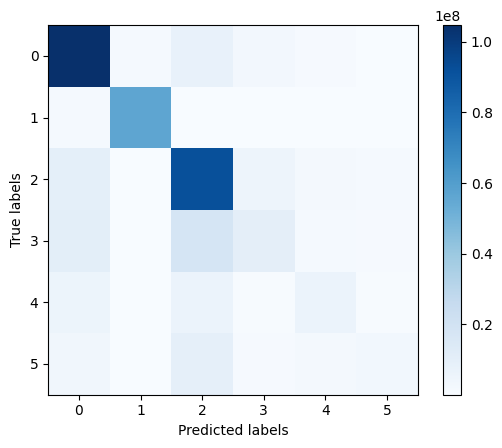

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(conf_matrix, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


## Inference Visualization
The function takes the following arguments:

* `images_filenames`: A list of image filenames.
* `images_directory`: A string representing the directory path where the images are located.
* `masks_directory`: A string representing the directory path where the masks are located.
* `predicted_masks`: A list of predicted masks (each predicted mask must have the same dimensions as its corresponding image).

The function starts by defining some variables such as the number of images to be displayed (n), the class names, the number of classes, and the color map. Then, for each image in the list of images, the function loads the image and its corresponding ground truth mask from their respective directories.

Next, the function plots the image in the first column of the grid, and the ground truth mask in the second column. The ground truth mask is overlaid on top of the image using a color map that maps each pixel value to its corresponding class color.

If `predicted_masks` are provided, the function plots them in the third column of the grid in the same way as the ground truth mask.

In [ ]:
from matplotlib import cm
import matplotlib.patches as mpatches

def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):

    # define the number of images to be displayed per row
    n = 3

    for i, image_filename in enumerate(images_filenames):
        # define the size of the resulting plot
        plt.figure(figsize=(20, 7))

        font_size = 'medium'

        # define the class names for the semantic segmentation task
        class_names = [
            'Background',
            'Estratocumuliform',
            'Estratiform',
            'Cirriform',
            'Cumuliform'
        ]

        # get the total number of classes
        n_classes = len(class_names)

        # get the colormap for the visualization
        cmap = plt.cm.get_cmap('tab20c', n_classes)

        # read the input image and the corresponding ground truth mask
        image_filename = images_filenames[len(images_filenames)-(i+1)]
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)

        # display the original image in the first column
        plt.subplot(1, n, 1)
        plt.title("Image", fontsize=font_size)
        plt.axis("off")
        plt.imshow(image)

        # create a colorbar for the ground truth mask visualization
        plt.clim(0, n_classes-1)
        clb = plt.colorbar(shrink=0.55)
        clb.set_ticks(range(n_classes))
        clb.ax.tick_params(labelsize=10)
        clb.ax.set_yticklabels(class_names)
        clb.ax.set_visible(False)

        # set the alpha value for the mask visualization
        mask_alpha = .5

        # display the ground truth mask in the second column
        plt.subplot(1, n, 2)
        plt.title("Ground Truth", fontsize=font_size)
        plt.axis("off")
        plt.imshow(image)
        plt.imshow(mask, interpolation="none", alpha=mask_alpha, cmap=cmap)

        # create a colorbar for the ground truth mask visualization
        plt.clim(0, n_classes-1)
        clb = plt.colorbar(shrink=0.55)
        clb.set_ticks(range(n_classes))
        clb.ax.tick_params(labelsize=10)
        clb.ax.set_yticklabels(class_names)
        clb.ax.set_visible(False)

        # if the predicted masks are provided, display them in the third column
        if predicted_masks is not None:
            predicted_mask = predicted_masks[len(images_filenames)-(i+1)]

            plt.subplot(1, n, 3)
            plt.title("Inference", fontsize=font_size)
            plt.axis("off")
            plt.imshow(image)
            plt.imshow(predicted_mask, interpolation="none", alpha=mask_alpha, cmap=cmap)

            # create a colorbar for the predicted mask visualization
            plt.clim(0, n_classes-1)
            clb = plt.colorbar(shrink=0.60, spacing='uniform')
            clb.set_ticks(range(n_classes))
            clb.ax.tick_params(labelsize=10)
            clb.ax.set_yticklabels(class_names)
            clb.ax.set_visible(True)

        # adjust the layout of the plot
        plt.tight_layout()

        # save the resulting plot to a file
        plt.savefig('path_to_save/results/' + image_filename)
        # plt.show()
        # break
        plt.clf()
        plt.cla()

In [ ]:
test_transform = A.Compose(
    [
        A.Resize(1280, 1280),
        ToTensorV2(),
     ]
)

# create the test dataset
test_dataset = OxfordPetInferenceDataset(test_images_filenames, test_images_directory, test_masks_directory, transform=test_transform)

# create the test dataloader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=params["num_workers"], pin_memory=True)

# Load the EfficientUNet-B0 model with specified parameters and load its weights from a saved checkpoint
model = get_efficientunet_b0(out_channels=5, concat_input=True, pretrained=True).to("cpu")
model.load_state_dict(torch.load("path_to_save/13.pth", map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()


# put the model on CPU
model = model.to("cpu")
model.eval()

# iterate over the test dataloader
with torch.no_grad():
    for batch_idx, (images, targets, filenames) in enumerate(test_loader):
        outputs = model(images.float())
        _, preds = torch.max(outputs, dim=1)

        # get original image sizes from the dataset
        original_sizes = [(cv2.imread(os.path.join(test_images_directory, filename))).shape[:2][::-1] for filename in filenames]

        # resize the predicted masks to the original size
        preds_resized = [cv2.resize(pred.cpu().numpy(), size, interpolation=cv2.INTER_NEAREST) for pred, size in zip(preds, original_sizes)]
        preds_resized = torch.tensor(preds_resized)

        display_image_grid(filenames, test_images_directory, test_masks_directory, predicted_masks=preds_resized)


In [ ]:
!rm -rf clouds1500_no_tree